# Virtual Synthesizer

All audio is basically signal data, manipulated by functions. Synthesizers use either analog or digital signals to create unique sounds. Here I experiment with creating a digital synthesizer using python.

In [15]:
import wave
import numpy as np
import matplotlib
from csv import reader as csv_reader
matplotlib.rcParams['figure.figsize'] = (12, 3)
from matplotlib import pyplot as plt
from IPython.display import Audio
from collections import namedtuple

# Constants
AUDIO_FILENAME = 'data/audio.wav'
SAMPLE_RATE = 44100.0  # 44.1 kHz sample rate (the standard)
SAMPLE_TYPE = np.int16 # Using 16-bit integers for samples

First let's start with learning how to create audio from scratch. I'm going to be using .wav files, since they have no compression and are easier to understand. Python provides the 'wave' library for reading and writing wav files.

A wave file contains some metadata and a raw dump of the audio sample data. Audio files work by having sound be represented as a series of discrete samples recorded at regular intervals. The value of these samples is the exact voltage that should be applied at the speaker at that time. Stitch these samples together and you get a rapid back-and-forth changing voltage which causes the speaker to move back and forth, producing sound.

The standard for sample rates in audio files is 44.1 kHz, about twice the highest frequency that (most) human ears can possibly hear.

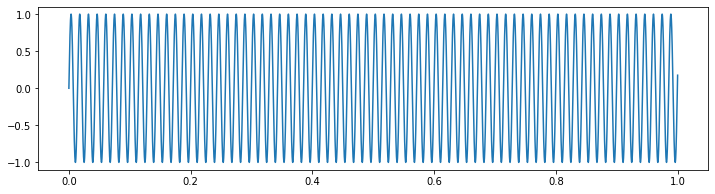

In [16]:
# Intermediary stuff
n_sample_bytes = np.iinfo(SAMPLE_TYPE).bits // 8 # Number of bytes in sample type
n_sample_max   = np.iinfo(SAMPLE_TYPE).max       # Maximum value of single sample

# Create a wave
a_freq = 440.0 # A note
duration = 1.0
t = np.linspace(0, duration, int(duration*SAMPLE_RATE))
a = np.sin(t*a_freq)

# Convert wave to binary data
b = a*n_sample_max
b = b.astype(SAMPLE_TYPE)
b = b.tobytes('C')

# Write audio
with wave.open(AUDIO_FILENAME, 'wb') as wv:
    wv.setnchannels(1)
    wv.setsampwidth(n_sample_bytes)
    wv.setframerate(SAMPLE_RATE)
    wv.writeframes(b)
    
# Display audio
plt.plot(t, a);
Audio(AUDIO_FILENAME)

Gonna clean this up and make a function out of it, take a set of data points from 0 to 1 and spit out an audio player

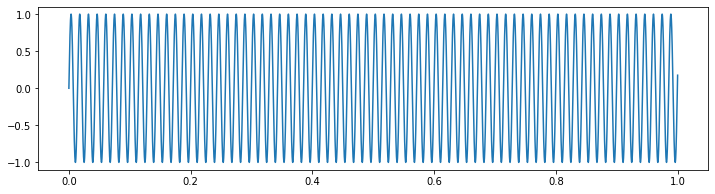

In [17]:
def play(signal, sample_rate=SAMPLE_RATE, sample_type=SAMPLE_TYPE, filename=AUDIO_FILENAME):
    """
    Play signal as audio
    """
    # Intermediary stuff
    n_sample_bytes = np.iinfo(sample_type).bits // 8 # Number of bytes in sample type
    n_sample_max   = np.iinfo(sample_type).max       # Maximum value of single sample
    
    # Convert wave to binary data
    signal_bytes = signal*n_sample_max
    signal_bytes = signal_bytes.astype(sample_type)
    signal_bytes = signal_bytes.tobytes('C')

    # Write audio
    with wave.open(filename, 'wb') as wv:
        wv.setnchannels(1)
        wv.setsampwidth(n_sample_bytes)
        wv.setframerate(sample_rate)
        wv.writeframes(signal_bytes)

    # Display audio
    return Audio(filename)


# Create a wave
a_freq = 440.0
duration = 1.0
t = np.linspace(0, duration, int(duration*SAMPLE_RATE))
a = np.sin(t*a_freq)

# Play wave
plt.plot(t, a);
play(a)

We can compose functions together to control waves. For example, we can turn a wave on and off using a step function

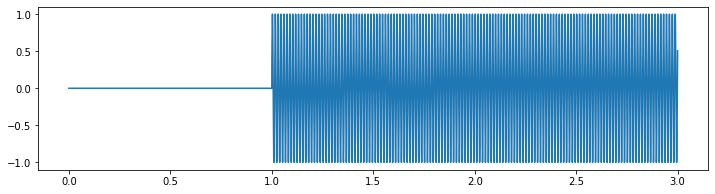

In [18]:
duration = 3.0
a_freq = 440.0
t = np.linspace(0, duration, int(duration*SAMPLE_RATE))
u = np.where(t >= 1.0, 1.0, 0.0)
a = np.sin(t*a_freq)
o = u*a

# Play audio
plt.plot(t, o);
play(o)

I'm going to use a better-looking interface with function factories. These will take parameters and create functions from those. I'll create a step function factory with a start time parameter and a sin factory with a frequency parameter

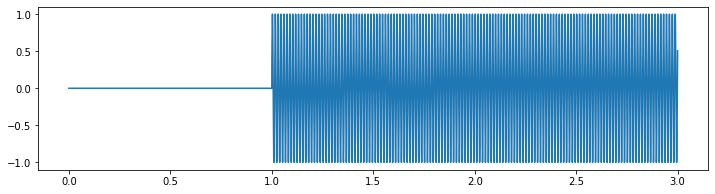

In [19]:
step = lambda start: lambda t: np.where(t >= start, 1.0, 0)
sin = lambda freq: lambda t: np.sin(t*freq)

t_space = lambda duration: np.linspace(0,
    duration,
    int(duration*SAMPLE_RATE)
)
    
# Input space
t = t_space(3.0)

# Create wave
u = step(1.0)(t)
a = sin(440.0)(t)
o = u*a

# Play audio
plt.plot(t, o);
play(o)

Modulate signal amplitude using a lower frequency sine wave

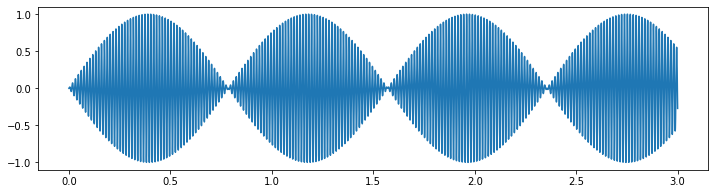

In [20]:
# Input space
t = t_space(3.0)

# Create wave
a = sin(440.0)(t)
l = sin(4)(t)
o = l*a

# Play audio
plt.plot(t, o)
play(o)

Now that sounds cool. Let's add some more notes separated by time. We can do that with a box function, with a start and end

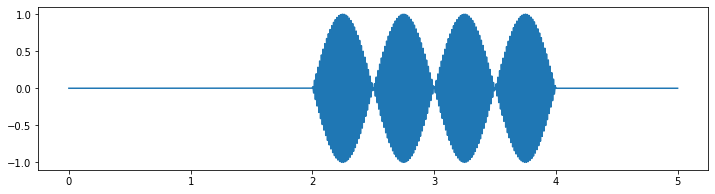

In [21]:
box = lambda start, end: lambda t: step(start)(t)*(1 - step(end)(t))

# Input space
t = t_space(5.0)

# Create wave
a = sin(440.0)(t)
l = sin(2*np.pi)(t - 2)
b = box(2, 4)(t)
o = a*l*b

# Play audio
plt.plot(t, o)
play(o)

Now we can string a bunch of these together to make multiple tones. Let's start with octaves of the note A. You can create an octave by multiplying the fundamental frequency by 2

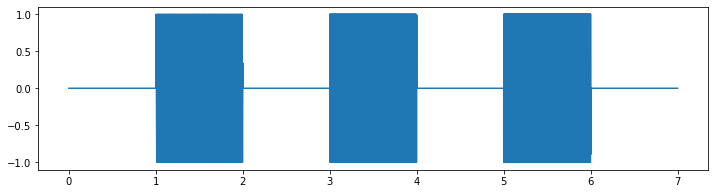

In [22]:
# Input space
t = t_space(7.0)

# Octaves
a0 = sin(440.0)(t)
b0 = box(1, 2)(t)
a1 = sin(440.0 * 2)(t)
b1 = box(3, 4)(t)
a2 = sin(440.0 * 4)(t)
b2 = box(5, 6)(t)

# Create signal
o = a0*b0 + a1*b1 + a2*b2

# Make sure we clip signal before we play it
aclip = lambda o: np.clip(o, -1, 1)
o = aclip(o)

# Play audio
plt.plot(t, o)
play(o)

Now let's write out all the note frequencies

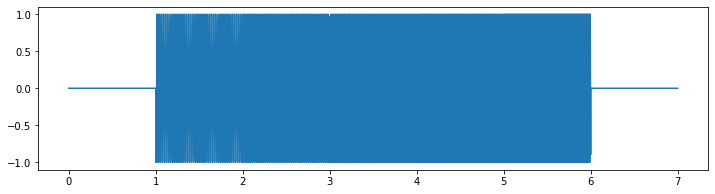

In [23]:
# Notes (_ means flat)
c  = 261.63
d_ = 277.18
d  = 293.66
e_ = 311.13
e  = 329.63
f  = 349.23
g_ = 369.99
g  = 392.00
a_ = 415.30
a  = 440.00
b_ = 466.16
b  = 493.88

# melody?
t = t_space(7.0)
o = sin(c)(t)*box(1, 2)(t) \
  + sin(d)(t)*box(2, 3)(t) \
  + sin(e)(t)*box(3, 4)(t) \
  + sin(g)(t)*box(4, 5)(t) \
  + sin(c*2)(t)*box(5, 6)(t)

# Play audio
o = aclip(o)
plt.plot(t, o)
play(o)

Try a chord

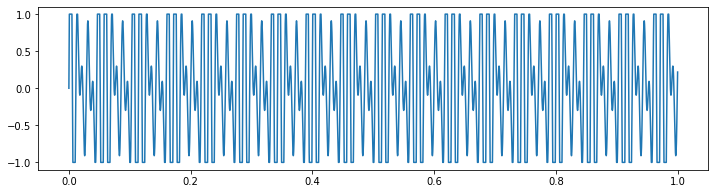

In [24]:
root = a
m3rd = root * 5/4
p5th = root * 3/2

# Chord?
t = t_space(1.0)
o = sin(root)(t) \
  + sin(m3rd)(t) \
  + sin(p5th)(t)

# Play audio
o = aclip(o)
plt.plot(t, o)
play(o)

Well... this is kinda bad... 

I found this [Wikipedia Article](https://en.wikipedia.org/wiki/Interval_(music)) on musical intervals. Going to read it.

So, pianos and other instruments are tuned using "cents". The "distance" in cents (labeled $n$) between two frequencies $f_2$ and $f_1$ defined using logarithms with this formula:.

$$
n = 1200 \log_2{ \left( \frac{f_2}{f_1} \right) }
$$

I'm actually intrigued by calling this a "distance" formula, since that is an abstraction that has multiple other uses in mathematics and physics. I might want to examine this more

Actually, I just remembered, we use a similar measurement in engineering (the decibel, or dB, which is a logarithmic measure of signal strength)

Or what I can do is just hardcode each frequency from a table. I found this [Wikipedia Article](https://en.wikipedia.org/wiki/Piano_key_frequencies) with note frequencies. This means though that I'll need a table with all of the frequencies. 

Or I could scrape it and create a csv file with that data, which I'll do in another notebook linked [here](/notebooks/webscraping.ipynb) to generate a notes csv file, which I will extract, turn into a dictionary, and use to play notes

So with that out of the way, we can use that data to create notes

In [25]:
# Read notes
key = namedtuple('key', 'num, note, freq')
keys = []
notes = {}
with open('data/notes.csv', 'r') as f:
    csv = csv_reader(f)
    keys = [
        key(int(num), note, float(freq))
        for num, note, freq in csv
    ]
    for key in keys:
        if '/' in key.note:
            sharp, flat = key.note.split('/')
            notes[sharp] = key
            notes[flat] = key
        else:
            notes[key.note] = key
notes

{'A0': key(num=1, note='A0', freq=27.5),
 'A♯0': key(num=2, note='A♯0/B♭0', freq=29.13524),
 'B♭0': key(num=2, note='A♯0/B♭0', freq=29.13524),
 'B0': key(num=3, note='B0', freq=30.86771),
 'C1': key(num=4, note='C1', freq=32.7032),
 'C♯1': key(num=5, note='C♯1/D♭1', freq=34.64783),
 'D♭1': key(num=5, note='C♯1/D♭1', freq=34.64783),
 'D1': key(num=6, note='D1', freq=36.7081),
 'D♯1': key(num=7, note='D♯1/E♭1', freq=38.89087),
 'E♭1': key(num=7, note='D♯1/E♭1', freq=38.89087),
 'E1': key(num=8, note='E1', freq=41.20344),
 'F1': key(num=9, note='F1', freq=43.65353),
 'F♯1': key(num=10, note='F♯1/G♭1', freq=46.2493),
 'G♭1': key(num=10, note='F♯1/G♭1', freq=46.2493),
 'G1': key(num=11, note='G1', freq=48.99943),
 'G♯1': key(num=12, note='G♯1/A♭1', freq=51.91309),
 'A♭1': key(num=12, note='G♯1/A♭1', freq=51.91309),
 'A1': key(num=13, note='A1', freq=55.0),
 'A♯1': key(num=14, note='A♯1/B♭1', freq=58.27047),
 'B♭1': key(num=14, note='A♯1/B♭1', freq=58.27047),
 'B1': key(num=15, note='B1', fr

Now let's try making a chord

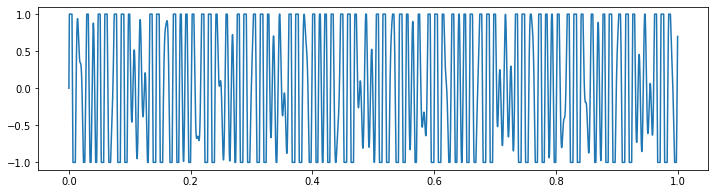

In [30]:
# Get notes
root = notes['A4'].freq
m3rd = notes['C5'].freq
p5th = notes['E5'].freq

# Create wave
t = t_space(1)
o = sin(root)(t) \
  + sin(m3rd)(t) \
  + sin(p5th)(t)

# Play audio
o = aclip(o)
plt.plot(t, o)
play(o)